In [16]:
import torch
import matplotlib.pyplot as plt
import torchvision.transforms as T
from torchvision.datasets import OxfordIIITPet
from torch.utils.data import DataLoader
from tqdm import tqdm

In [3]:
dataset = OxfordIIITPet("/content/drive/MyDrive/DLE/OxfordPets", target_types="segmentation", download=True)

100%|██████████| 791918971/791918971 [00:24<00:00, 32478348.78it/s]


Extracting /content/drive/MyDrive/DLE/OxfordPets/oxford-iiit-pet/images.tar.gz to /content/drive/MyDrive/DLE/OxfordPets/oxford-iiit-pet


100%|██████████| 19173078/19173078 [00:01<00:00, 14869928.40it/s]


Extracting /content/drive/MyDrive/DLE/OxfordPets/oxford-iiit-pet/annotations.tar.gz to /content/drive/MyDrive/DLE/OxfordPets/oxford-iiit-pet


In [4]:
dataset[0]

(<PIL.Image.Image image mode=RGB size=394x500>,
 <PIL.PngImagePlugin.PngImageFile image mode=L size=394x500>)

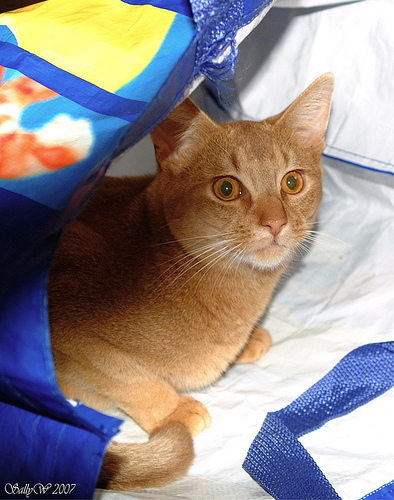

In [6]:
dataset[0][0]

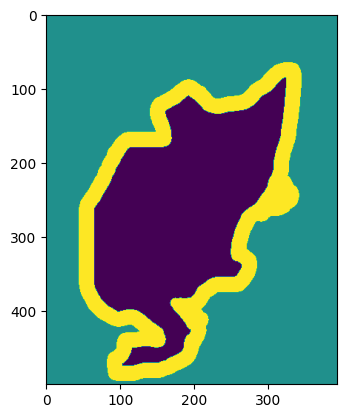

In [9]:
plt.imshow(dataset[0][1])

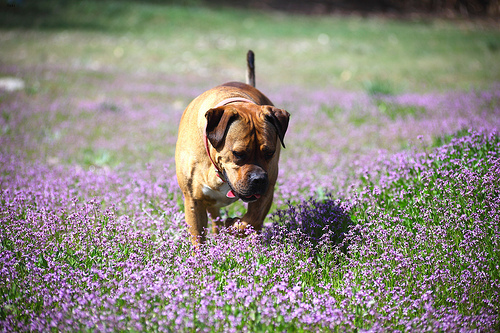

In [10]:
dataset[50][0]

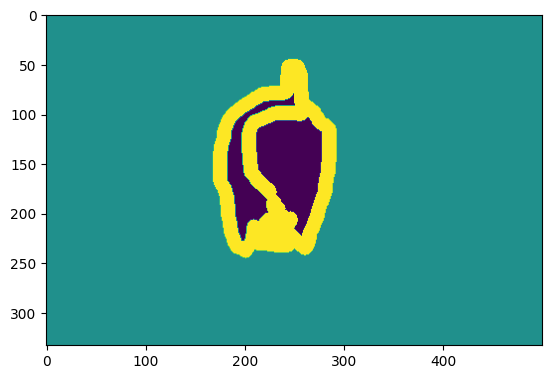

In [12]:
plt.imshow(dataset[50][1])

In [14]:
transforms = T.Compose(
    [
        T.Resize((128, 128)),
        T.ToTensor(),
    ]
)

target_transforms = T.Compose(
    [
        T.Resize((128, 128)),
        T.PILToTensor(),
        T.Lambda(lambda x: (x - 1).long())
    ]
)

In [15]:
train_dataset = OxfordIIITPet("/content/drive/MyDrive/DLE/OxfordPets", transform=transforms, target_transform=target_transforms, target_types="segmentation")
valid_dataset = OxfordIIITPet("/content/drive/MyDrive/DLE/OxfordPets", transform=transforms, target_transform=target_transforms, target_types="segmentation", split="test")

In [17]:
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=2, pin_memory=True)
valid_loader = DataLoader(valid_dataset, batch_size=64, shuffle=False, num_workers=2, pin_memory=True)

In [30]:
def train(model) -> float:
    model.train()

    train_loss = 0
    total = 0
    correct = 0

    for x, y in tqdm(train_loader, desc="Train"):
        bs = y.size(0)

        x, y = x.to(device), y.squeeze(1).to(device)
        optimizer.zero_grad()
        output = model(x)
        loss = loss_fn(output.reshape(bs, 3, -1), y.reshape(bs, -1))
        train_loss += loss.item()
        loss.backward()
        optimizer.step()

        _, y_pred = output.max(dim=1)
        total += y.size(0) * y.size(1) * y.size(2)
        correct += (y == y_pred).sum().item()

    train_loss /= len(train_loader)
    accuracy = correct / total

    return train_loss, accuracy